In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from lightgbm.sklearn import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor


In [2]:
df = pd.read_csv('household_power_consumption.csv')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17.0
1,16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   1048575 non-null  object 
 1   Time                   1048575 non-null  object 
 2   Global_active_power    1048575 non-null  object 
 3   Global_reactive_power  1048575 non-null  object 
 4   Voltage                1048575 non-null  object 
 5   Global_intensity       1048575 non-null  object 
 6   Sub_metering_1         1048575 non-null  object 
 7   Sub_metering_2         1048575 non-null  object 
 8   Sub_metering_3         1044506 non-null  float64
dtypes: float64(1), object(8)
memory usage: 72.0+ MB


In [4]:
df.shape

(1048575, 9)

In [5]:
df.isnull().sum()/len(df)

Date                     0.000000
Time                     0.000000
Global_active_power      0.000000
Global_reactive_power    0.000000
Voltage                  0.000000
Global_intensity         0.000000
Sub_metering_1           0.000000
Sub_metering_2           0.000000
Sub_metering_3           0.003881
dtype: float64

In [6]:
df[df['Sub_metering_3'].isnull()]

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,21/12/2006,11:23:00,?,?,?,?,?,?,NaN
6840,21/12/2006,11:24:00,?,?,?,?,?,?,NaN
19724,30/12/2006,10:08:00,?,?,?,?,?,?,NaN
19725,30/12/2006,10:09:00,?,?,?,?,?,?,NaN
41832,14/1/2007,18:36:00,?,?,?,?,?,?,NaN
...,...,...,...,...,...,...,...,...,...
1043669,10/12/2008,11:53:00,?,?,?,?,?,?,NaN
1043670,10/12/2008,11:54:00,?,?,?,?,?,?,NaN
1043671,10/12/2008,11:55:00,?,?,?,?,?,?,NaN
1043672,10/12/2008,11:56:00,?,?,?,?,?,?,NaN


In [7]:
df[df['Voltage'] == '?'].count()

Date                     4069
Time                     4069
Global_active_power      4069
Global_reactive_power    4069
Voltage                  4069
Global_intensity         4069
Sub_metering_1           4069
Sub_metering_2           4069
Sub_metering_3              0
dtype: int64

In [8]:
df.fillna(0, inplace=True)
for col in df.iloc[:, 2:].columns:
    df[col].replace('?', 0, inplace=True)

In [9]:
df.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [10]:
df.iloc[6839]

Date                     21/12/2006
Time                       11:23:00
Global_active_power               0
Global_reactive_power             0
Voltage                           0
Global_intensity                  0
Sub_metering_1                    0
Sub_metering_2                    0
Sub_metering_3                  0.0
Name: 6839, dtype: object

In [11]:
for col in df.iloc[:,2:].columns:
    df[col] = df[col].astype('float64')

In [12]:
df['Date_Time'] = df['Date'] + ' ' + df['Time']

In [13]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df['Month_name'] = df['Date_Time'].dt.month_name()
df['Day_of_week_name'] = df['Date_Time'].dt.day_name()

C:\Users\dgmur\AppData\Local\Temp\ipykernel_134760\38009187.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date_Time'] = pd.to_datetime(df['Date_Time'])


In [14]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date_Time,Month_name,Day_of_week_name
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,December,Saturday
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,December,Saturday
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,December,Saturday
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,December,Saturday
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,December,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,13/12/2008,21:34:00,0.426,0.076,242.27,1.8,0.0,0.0,0.0,2008-12-13 21:34:00,December,Saturday
1048571,13/12/2008,21:35:00,0.424,0.076,242.10,1.8,0.0,0.0,0.0,2008-12-13 21:35:00,December,Saturday
1048572,13/12/2008,21:36:00,0.422,0.076,241.73,1.8,0.0,0.0,0.0,2008-12-13 21:36:00,December,Saturday
1048573,13/12/2008,21:37:00,0.422,0.078,242.56,1.8,0.0,0.0,0.0,2008-12-13 21:37:00,December,Saturday


In [15]:
df['year'] = df['Date_Time'].dt.year
df['month'] = df['Date_Time'].dt.month
df['Day_of_week'] = df['Date_Time'].dt.day_of_week

In [16]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date_Time,Month_name,Day_of_week_name,year,month,Day_of_week
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,December,Saturday,2006,12,5
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,December,Saturday,2006,12,5
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,December,Saturday,2006,12,5
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,December,Saturday,2006,12,5
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,December,Saturday,2006,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,13/12/2008,21:34:00,0.426,0.076,242.27,1.8,0.0,0.0,0.0,2008-12-13 21:34:00,December,Saturday,2008,12,5
1048571,13/12/2008,21:35:00,0.424,0.076,242.10,1.8,0.0,0.0,0.0,2008-12-13 21:35:00,December,Saturday,2008,12,5
1048572,13/12/2008,21:36:00,0.422,0.076,241.73,1.8,0.0,0.0,0.0,2008-12-13 21:36:00,December,Saturday,2008,12,5
1048573,13/12/2008,21:37:00,0.422,0.078,242.56,1.8,0.0,0.0,0.0,2008-12-13 21:37:00,December,Saturday,2008,12,5


In [17]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date_Time,year,month,Day_of_week
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1048575,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.103902e+00,1.178142e-01,2.390286e+02,4.699814e+00,1.172882e+00,1.469452e+00,5.910810e+00,2007-12-15 19:31:00.000001792,2.007457e+03,6.498591e+00,3.000486e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2006-12-16 17:24:00,2.006000e+03,1.000000e+00,0.000000e+00
25%,2.860000e-01,0.000000e+00,2.379300e+02,1.200000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2007-06-16 18:27:30,2.007000e+03,4.000000e+00,1.000000e+00
50%,5.420000e-01,9.800000e-02,2.402000e+02,2.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2007-12-15 19:31:00,2.007000e+03,7.000000e+00,3.000000e+00
75%,1.542000e+00,1.860000e-01,2.421400e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,2008-06-14 20:34:30,2.008000e+03,9.000000e+00,5.000000e+00
max,1.067000e+01,1.390000e+00,2.521400e+02,4.640000e+01,8.000000e+01,7.800000e+01,3.100000e+01,2008-12-13 21:38:00,2.008000e+03,1.200000e+01,6.000000e+00
std,1.129456e+00,1.095406e-01,1.527486e+01,4.763377e+00,6.309331e+00,6.341029e+00,8.202752e+00,NaN,5.385978e-01,3.439283e+00,2.000001e+00


In [18]:
year_month_day_features = ['year', 'Month_name', 'Day_of_week_name']



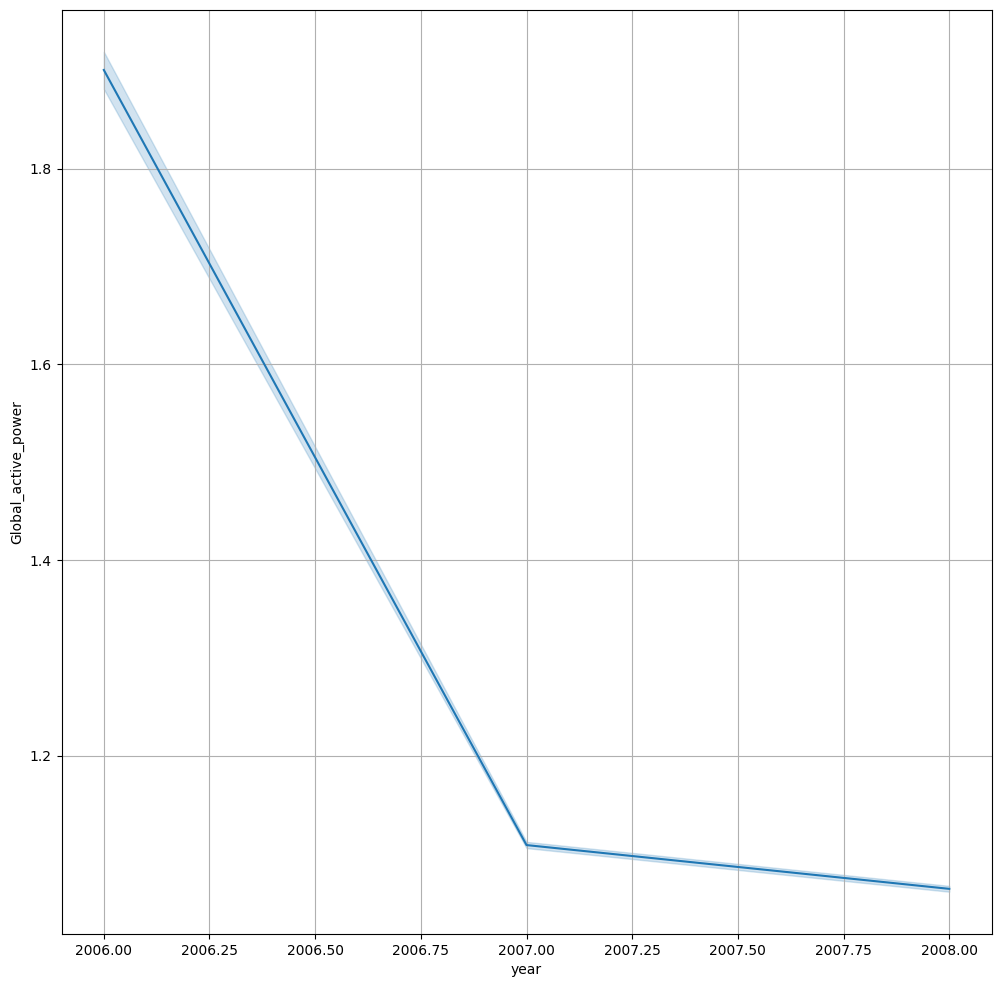

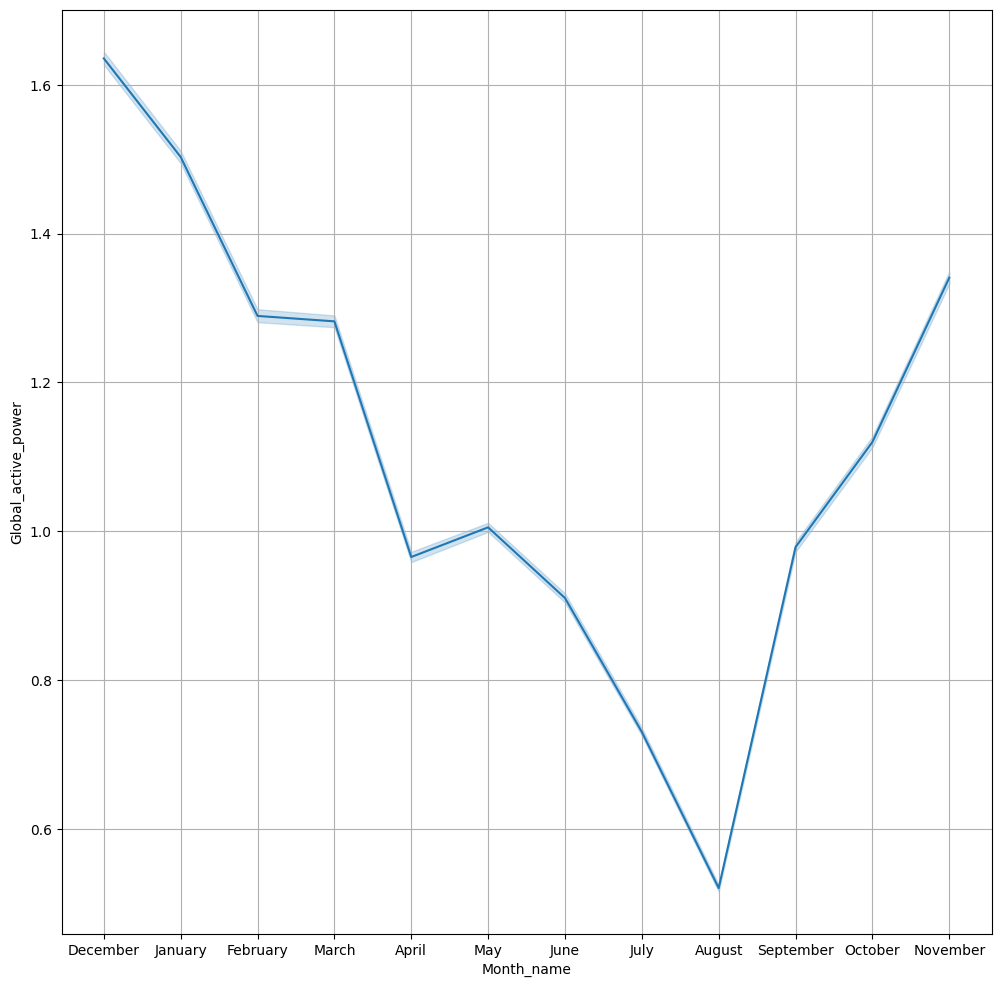

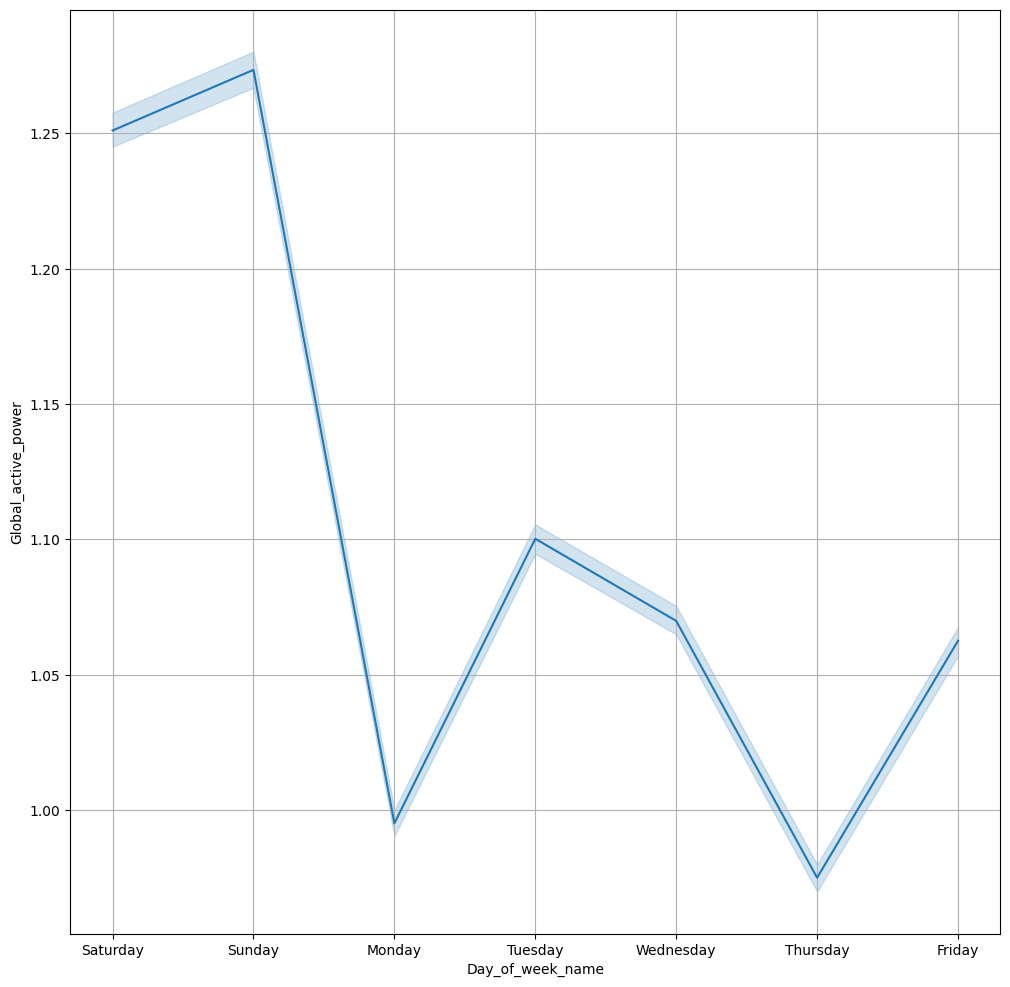

In [19]:

for feature in year_month_day_features:
    plt.figure(figsize=(12,12))
    sns.lineplot(data = df, x = feature, y = 'Global_active_power')
    plt.grid()
    plt.show()

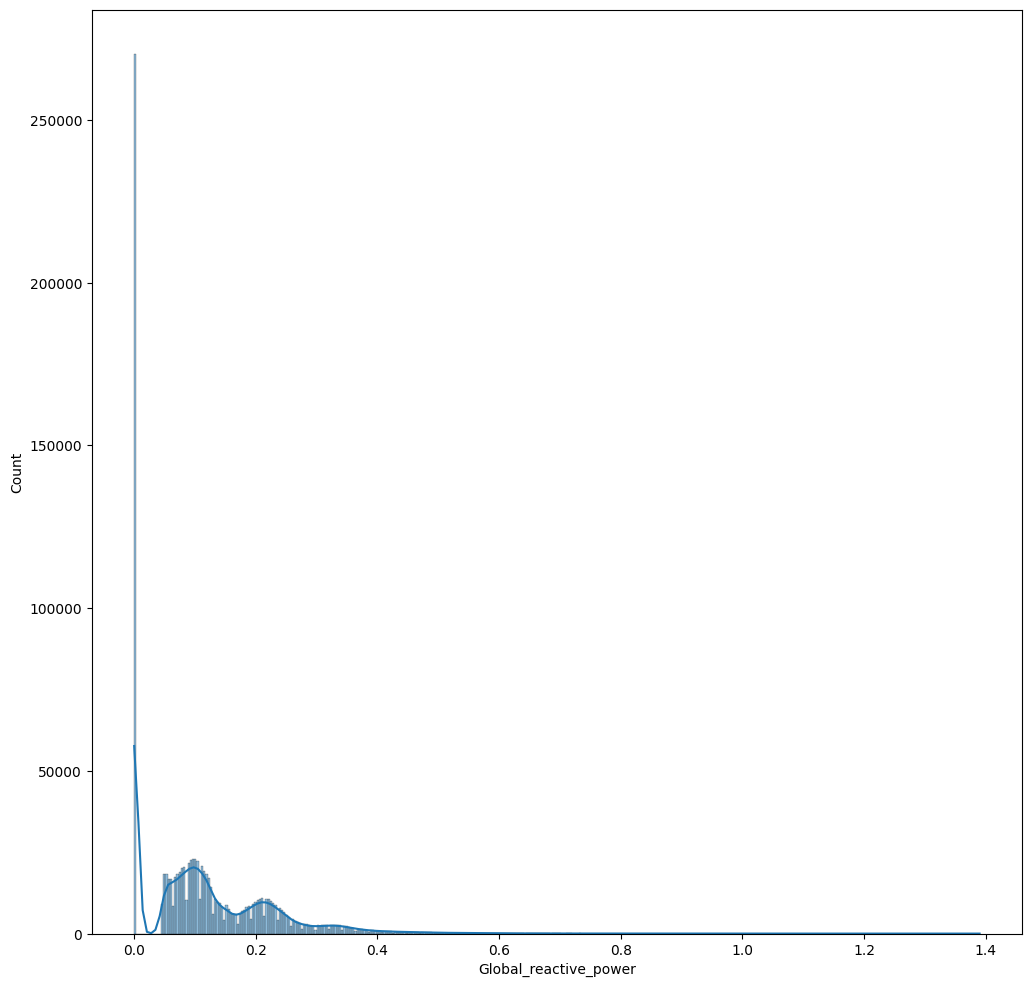

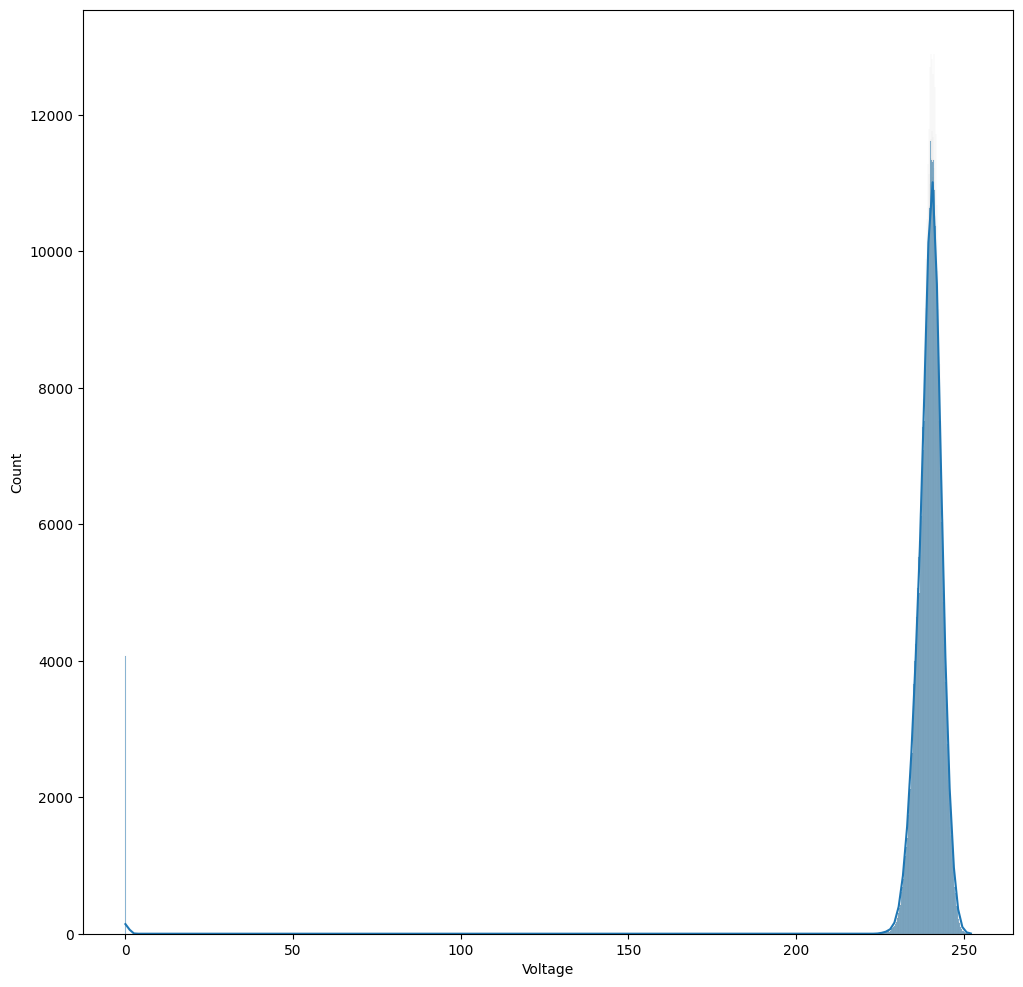

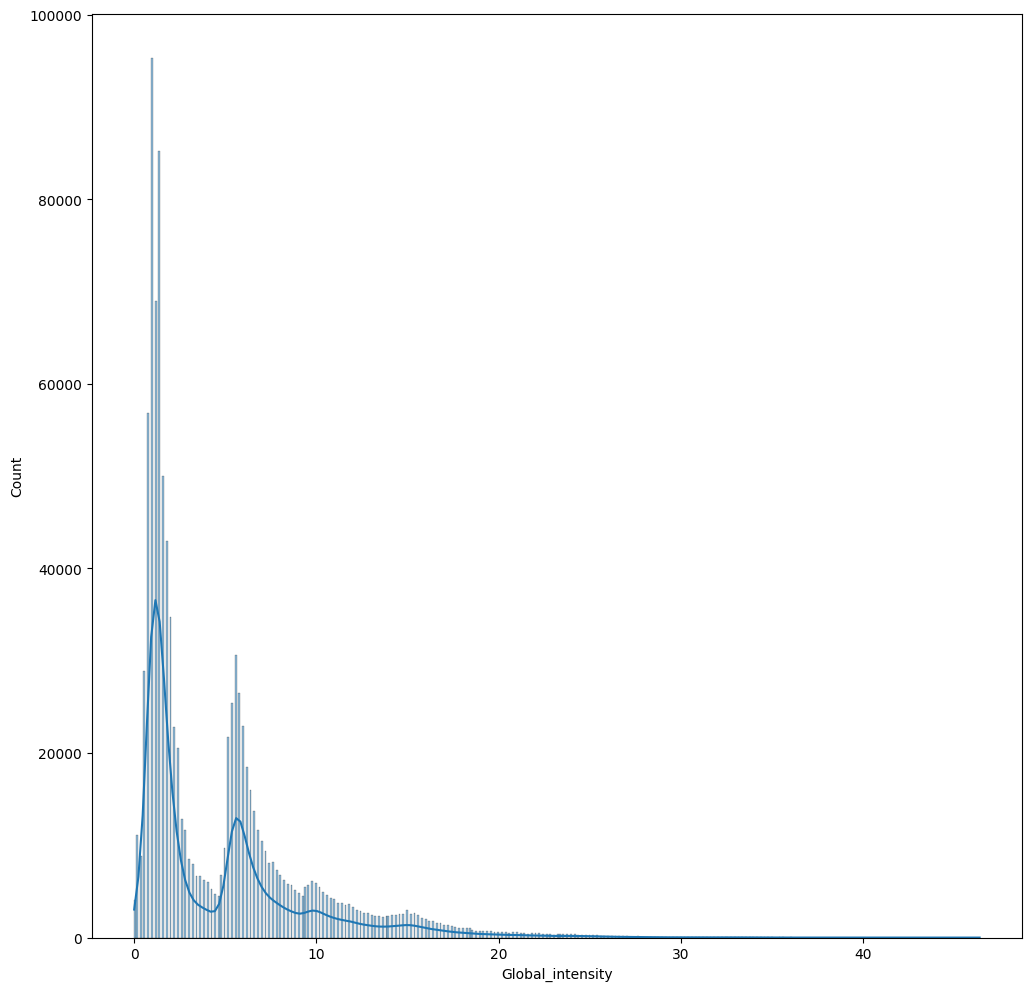

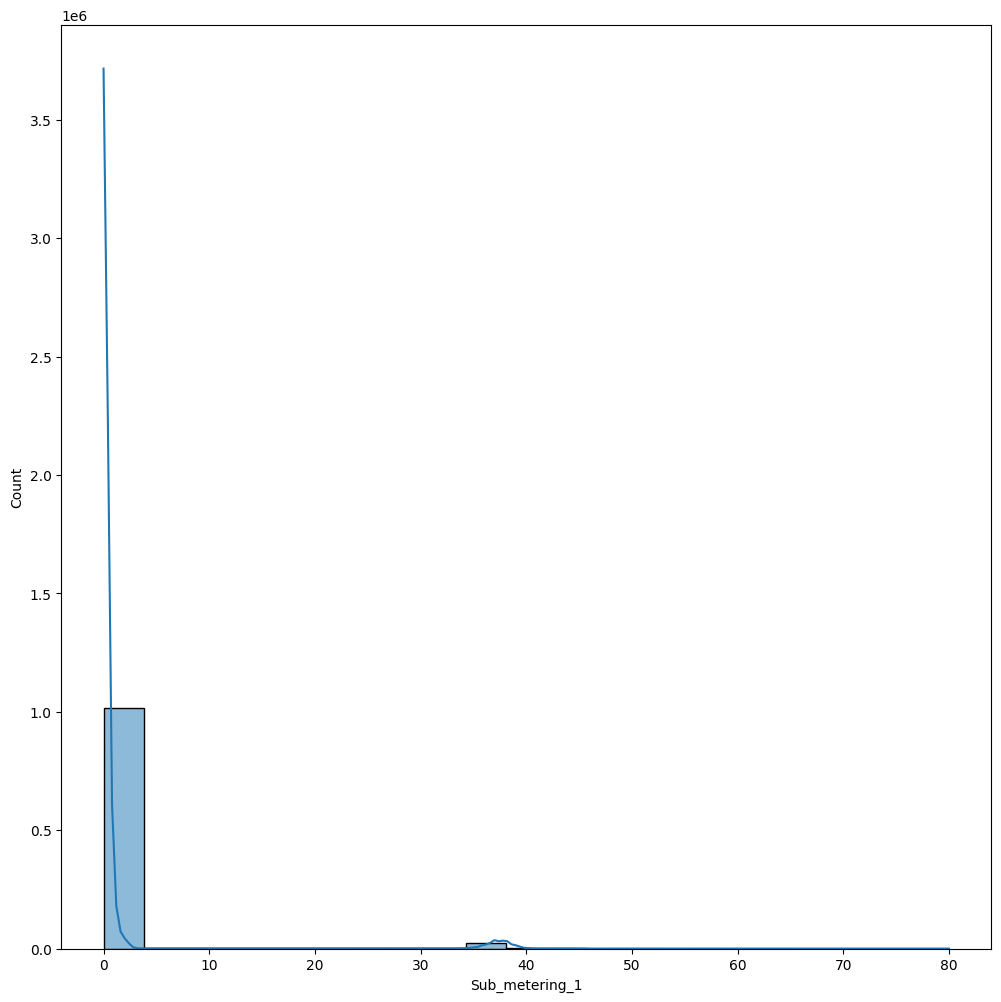

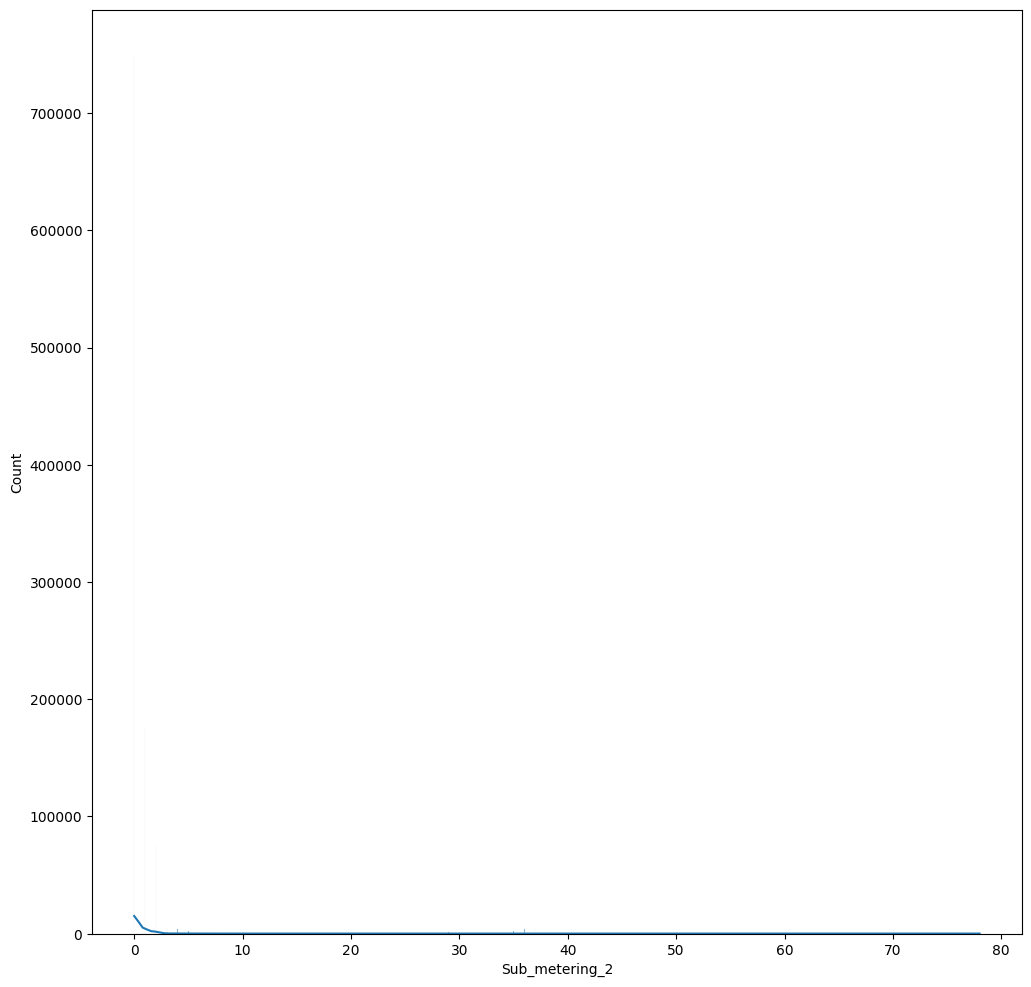

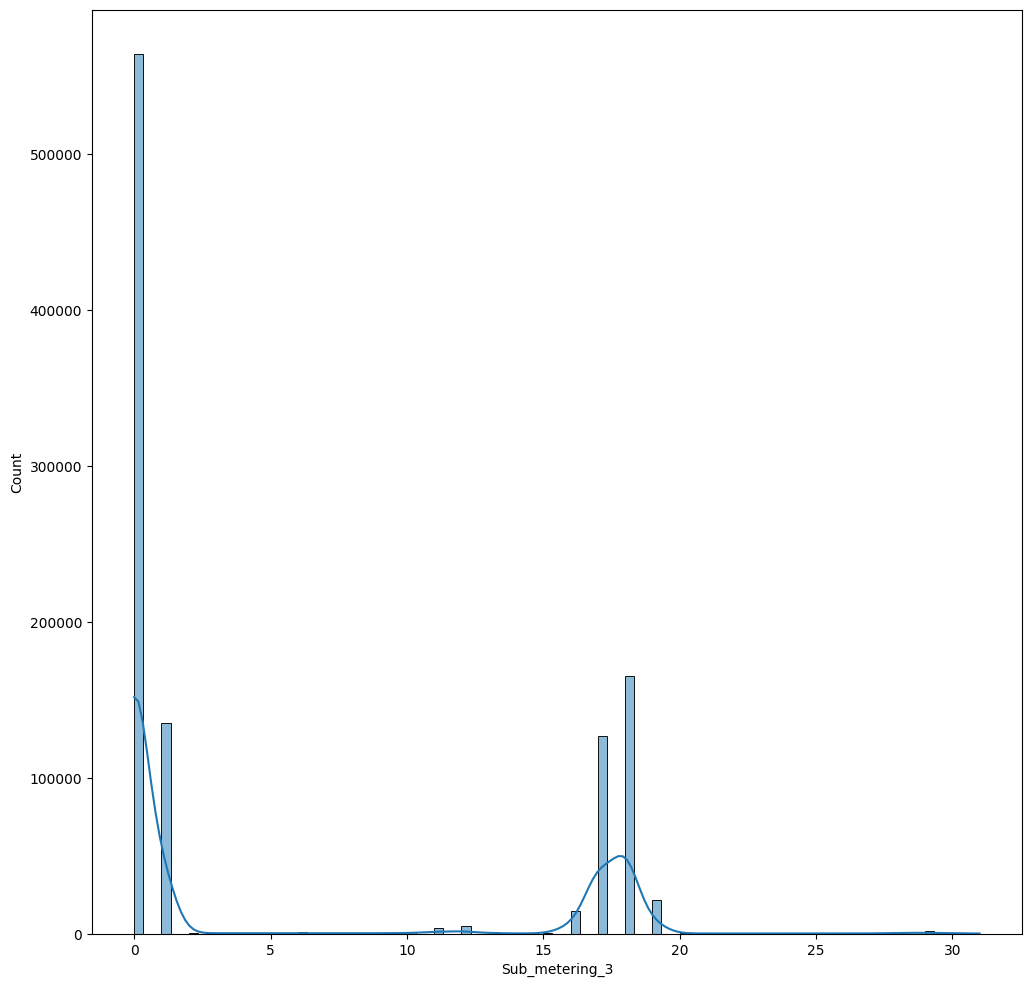

In [20]:
for f in df.iloc[:,3:9].columns:
    plt.figure(figsize = (12,12))
    sns.histplot(data = df, x = f, kde=True)
    plt.show()

In [21]:
df.drop(['Date', 'Time'], axis = 1, inplace= True)
df.set_index('Date_Time', inplace=True)

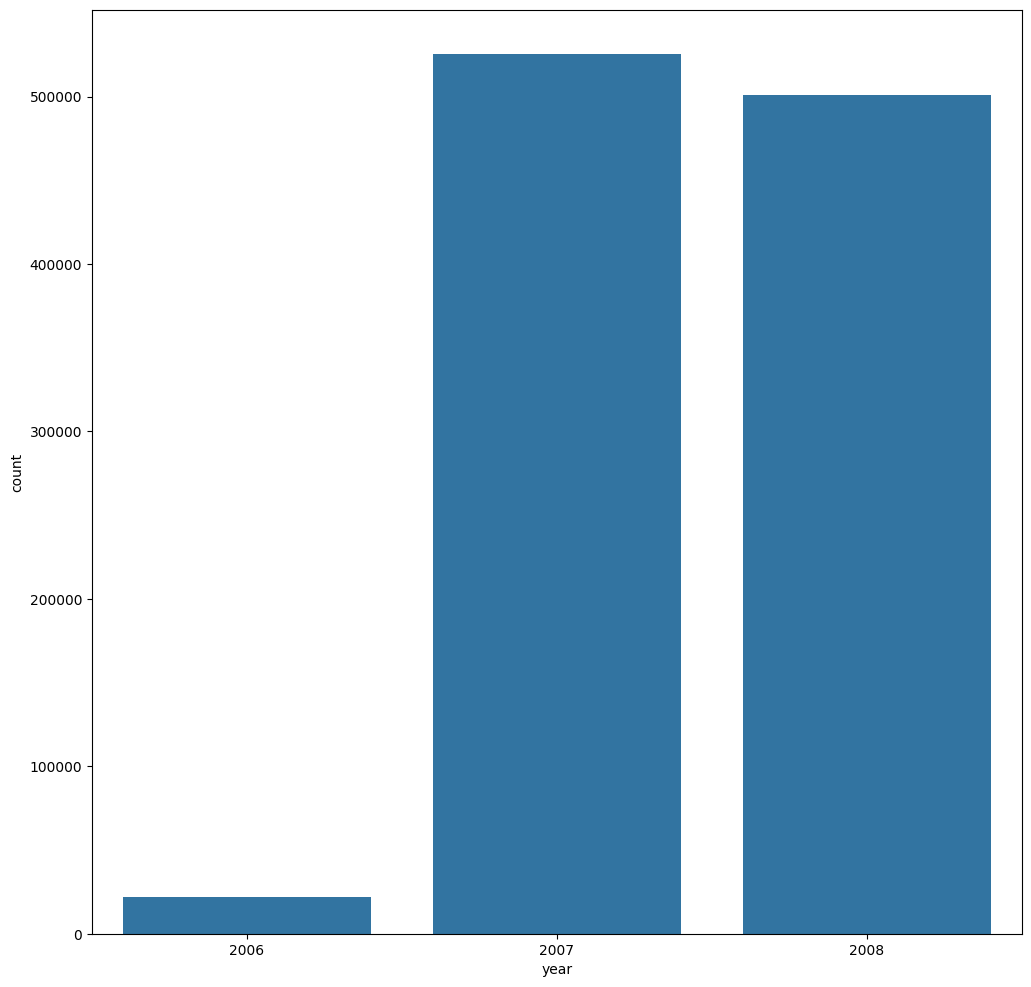

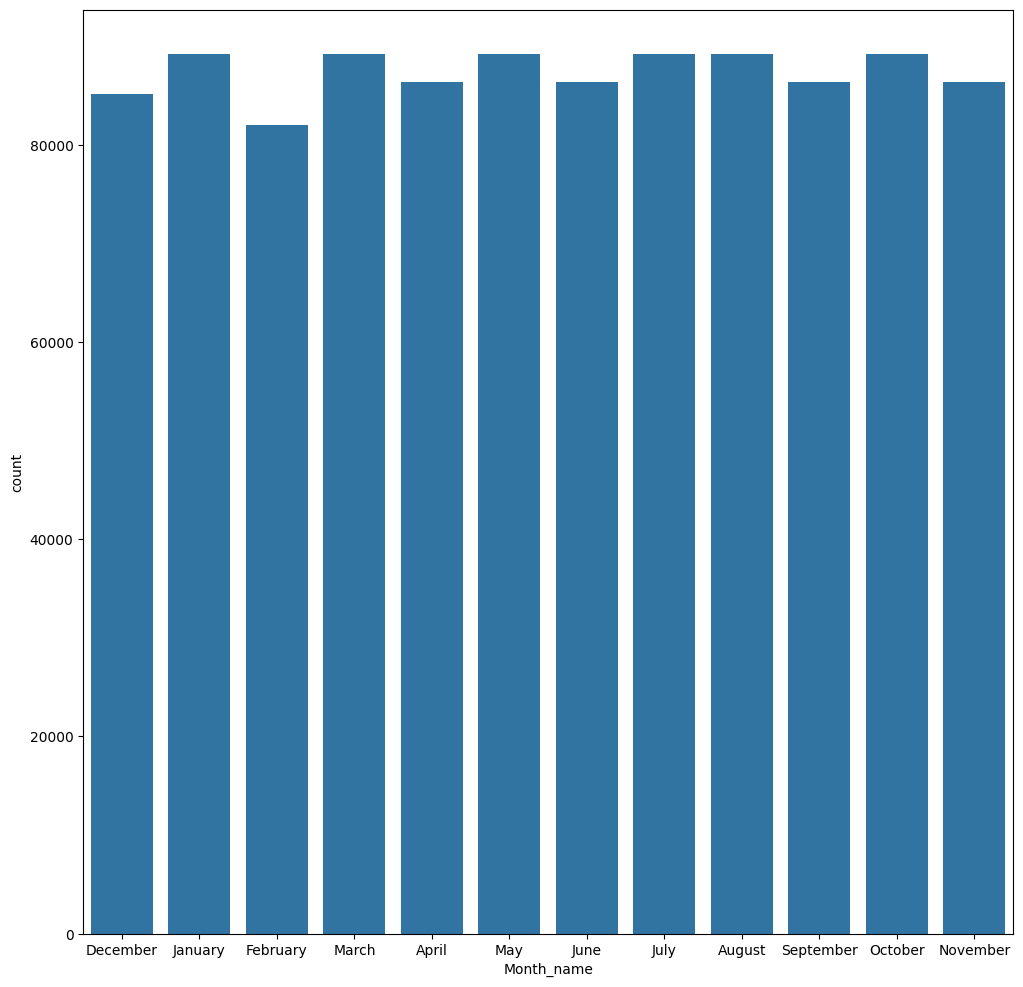

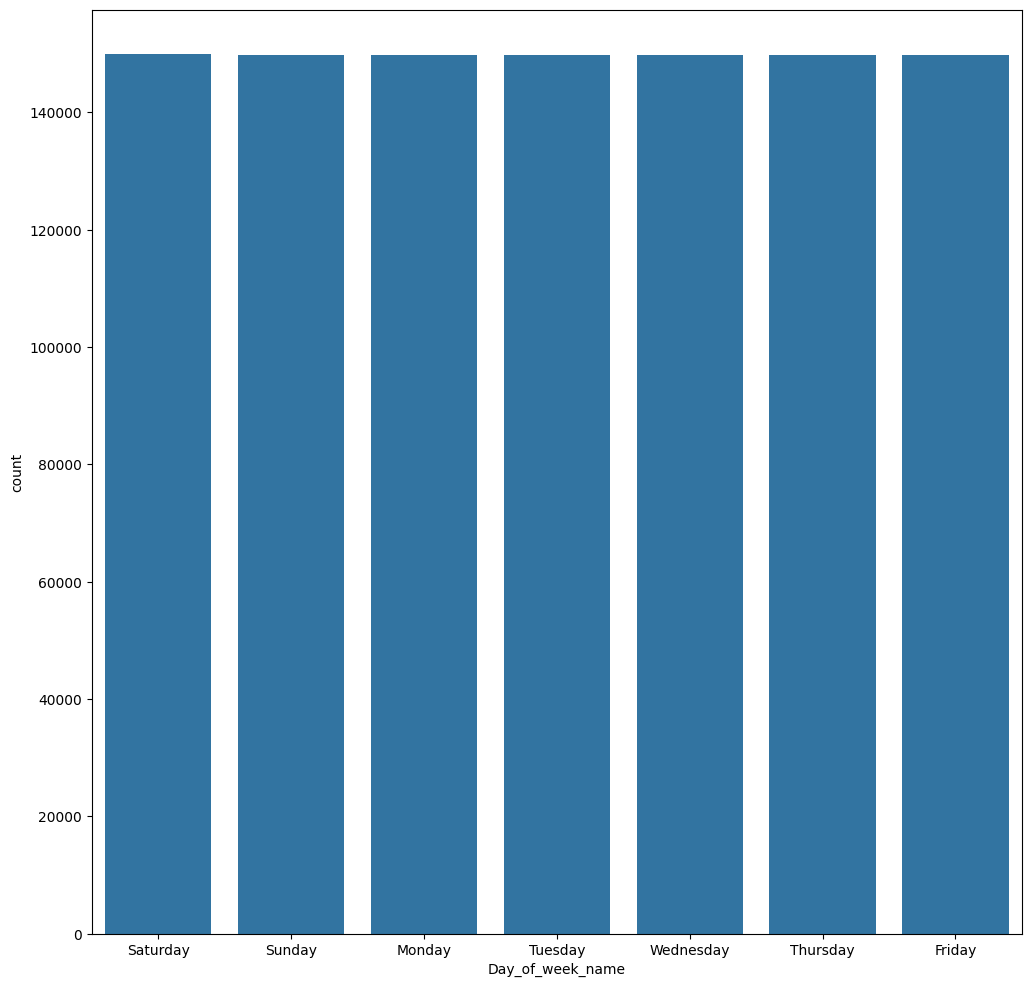

In [22]:
for feat in year_month_day_features:
    plt.figure(figsize = (12,12))
    sns.countplot(data =df, x = feat)
    plt.show()

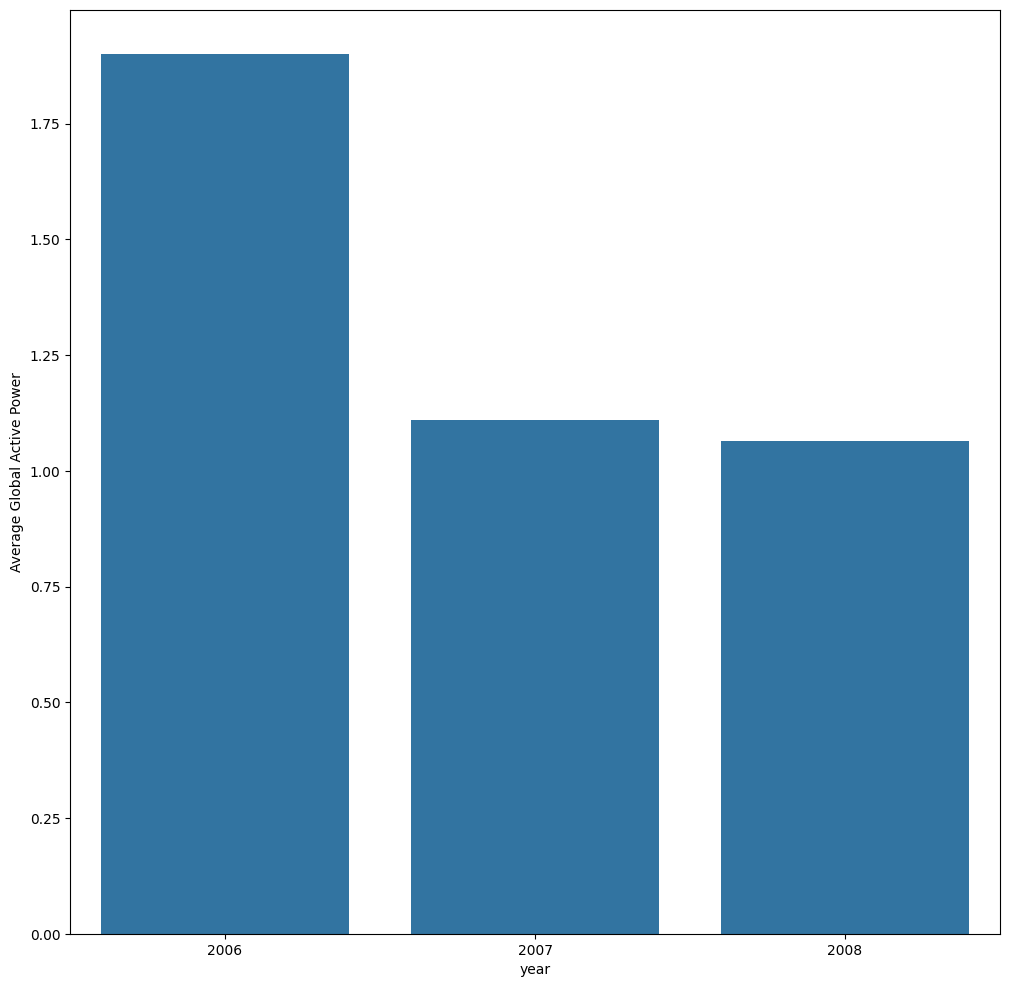

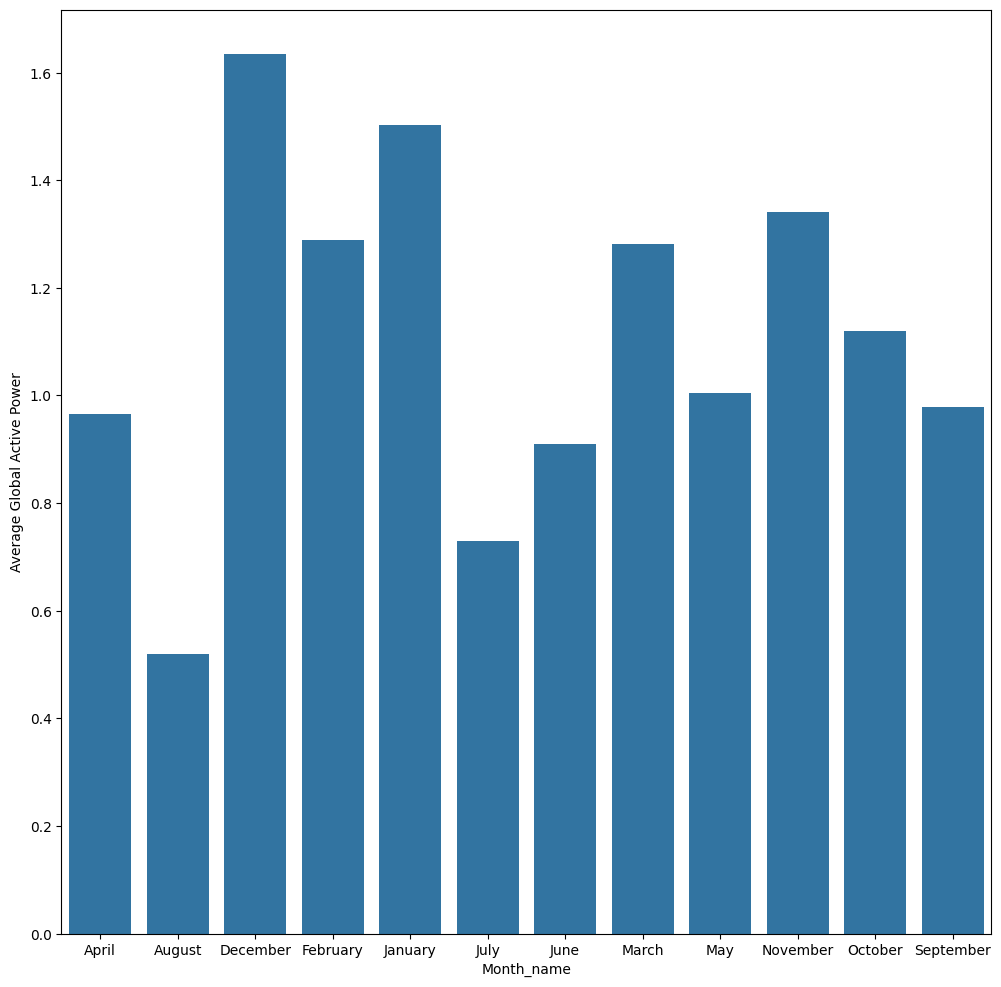

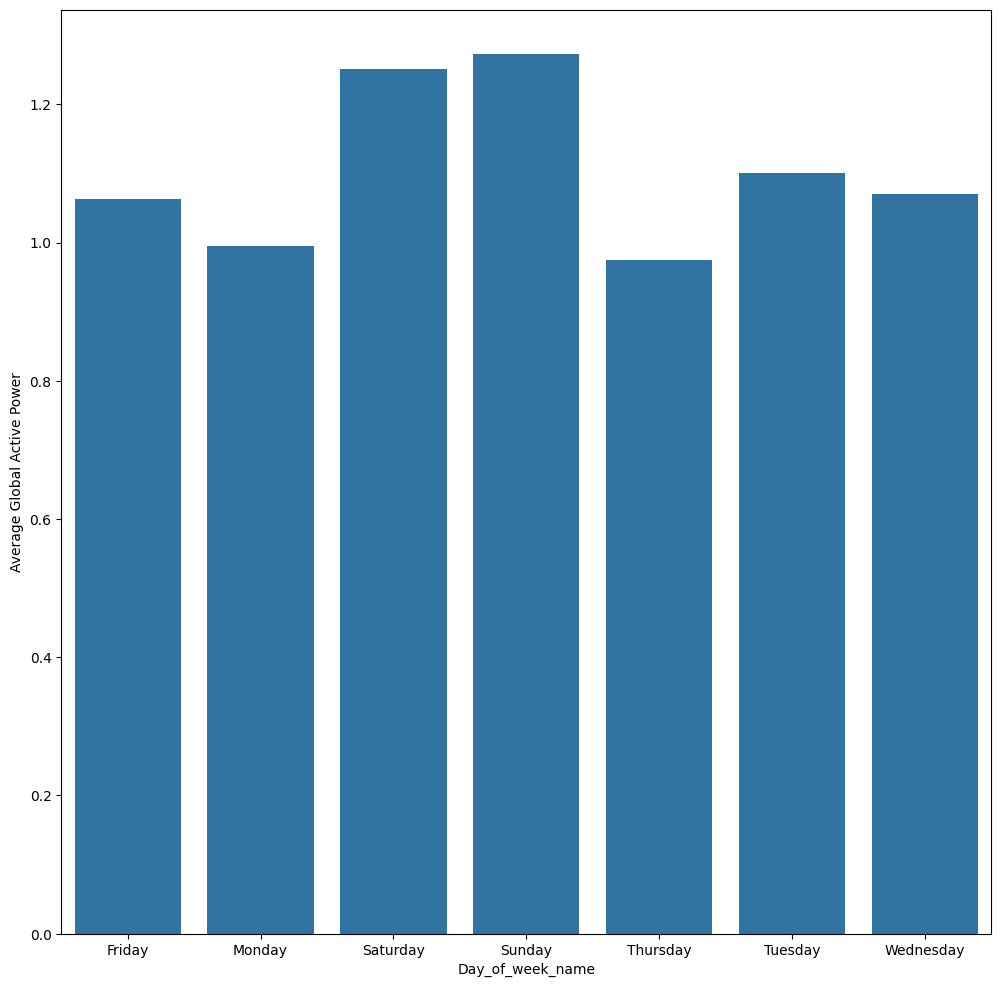

In [23]:
for feat in year_month_day_features:
    plt.figure(figsize = (12,12))
    grouped_data = df.groupby(feat)['Global_active_power'].mean().reset_index(name='Average Global Active Power')
    sns.barplot(data = grouped_data, x = feat, y = 'Average Global Active Power')
    plt.show()

In [24]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month_name,Day_of_week_name,year,month,Day_of_week
Date_Time,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,December,Saturday,2006,12,5
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,December,Saturday,2006,12,5
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,December,Saturday,2006,12,5
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,December,Saturday,2006,12,5
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,December,Saturday,2006,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-13 21:34:00,0.426,0.076,242.27,1.8,0.0,0.0,0.0,December,Saturday,2008,12,5
2008-12-13 21:35:00,0.424,0.076,242.10,1.8,0.0,0.0,0.0,December,Saturday,2008,12,5
2008-12-13 21:36:00,0.422,0.076,241.73,1.8,0.0,0.0,0.0,December,Saturday,2008,12,5


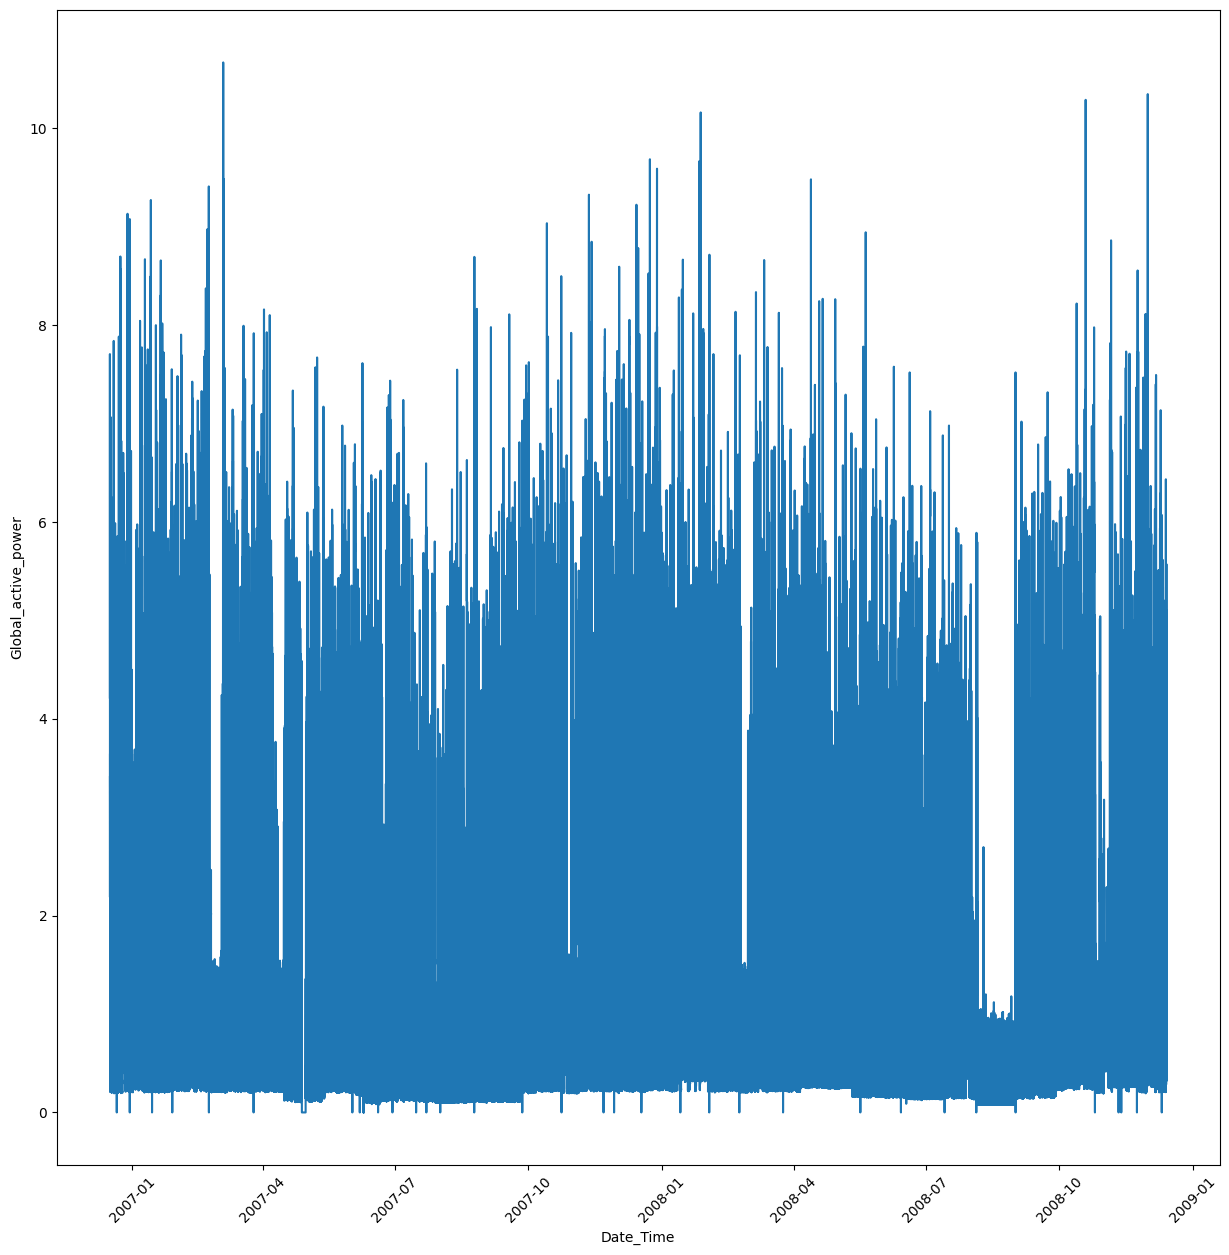

In [25]:

plt.figure(figsize=(15,15))
sns.lineplot(df, x = df.index, y = 'Global_active_power')
plt.xticks(rotation = 45)
plt.show()

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


In [27]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month_name,Day_of_week_name,year,month,Day_of_week
Date_Time,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,December,Saturday,2006,12,5
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,December,Saturday,2006,12,5
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,December,Saturday,2006,12,5
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,December,Saturday,2006,12,5
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,December,Saturday,2006,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-13 21:34:00,0.426,0.076,242.27,1.8,0.0,0.0,0.0,December,Saturday,2008,12,5
2008-12-13 21:35:00,0.424,0.076,242.10,1.8,0.0,0.0,0.0,December,Saturday,2008,12,5
2008-12-13 21:36:00,0.422,0.076,241.73,1.8,0.0,0.0,0.0,December,Saturday,2008,12,5


In [28]:
df.drop(['Month_name', 'Day_of_week_name', 'month', 'Day_of_week', 'year'], axis = 1, inplace = True)

lag_features = [1,2,3]

for columns in df.columns:
    for lag in lag_features:
        df[f'{columns}_lag_{lag}'] = df[columns].shift(lag)


In [29]:
df = df.bfill()

In [30]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power_lag_1,Global_active_power_lag_2,Global_active_power_lag_3,...,Global_intensity_lag_3,Sub_metering_1_lag_1,Sub_metering_1_lag_2,Sub_metering_1_lag_3,Sub_metering_2_lag_1,Sub_metering_2_lag_2,Sub_metering_2_lag_3,Sub_metering_3_lag_1,Sub_metering_3_lag_2,Sub_metering_3_lag_3
Date_Time,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,4.216,4.216,4.216,...,18.4,0.0,0.0,0.0,1.0,1.0,1.0,17.0,17.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,4.216,4.216,4.216,...,18.4,0.0,0.0,0.0,1.0,1.0,1.0,17.0,17.0,17.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,5.360,4.216,4.216,...,18.4,0.0,0.0,0.0,1.0,1.0,1.0,16.0,17.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,5.374,5.360,4.216,...,18.4,0.0,0.0,0.0,2.0,1.0,1.0,17.0,16.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,5.388,5.374,5.360,...,23.0,0.0,0.0,0.0,1.0,2.0,1.0,17.0,17.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-13 21:34:00,0.426,0.076,242.27,1.8,0.0,0.0,0.0,0.422,0.420,0.418,...,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-12-13 21:35:00,0.424,0.076,242.10,1.8,0.0,0.0,0.0,0.426,0.422,0.420,...,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-12-13 21:36:00,0.422,0.076,241.73,1.8,0.0,0.0,0.0,0.424,0.426,0.422,...,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df.isnull().sum()

Global_active_power            0
Global_reactive_power          0
Voltage                        0
Global_intensity               0
Sub_metering_1                 0
Sub_metering_2                 0
Sub_metering_3                 0
Global_active_power_lag_1      0
Global_active_power_lag_2      0
Global_active_power_lag_3      0
Global_reactive_power_lag_1    0
Global_reactive_power_lag_2    0
Global_reactive_power_lag_3    0
Voltage_lag_1                  0
Voltage_lag_2                  0
Voltage_lag_3                  0
Global_intensity_lag_1         0
Global_intensity_lag_2         0
Global_intensity_lag_3         0
Sub_metering_1_lag_1           0
Sub_metering_1_lag_2           0
Sub_metering_1_lag_3           0
Sub_metering_2_lag_1           0
Sub_metering_2_lag_2           0
Sub_metering_2_lag_3           0
Sub_metering_3_lag_1           0
Sub_metering_3_lag_2           0
Sub_metering_3_lag_3           0
dtype: int64

In [32]:
seasonal = seasonal_decompose(df['Global_active_power'], model='additive', period=1440, extrapolate_trend='freq')

In [33]:
df['global_active_power_seasonal'] = seasonal.seasonal
df['global_active_power_trend'] = seasonal.trend
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power_lag_1,Global_active_power_lag_2,Global_active_power_lag_3,...,Sub_metering_1_lag_2,Sub_metering_1_lag_3,Sub_metering_2_lag_1,Sub_metering_2_lag_2,Sub_metering_2_lag_3,Sub_metering_3_lag_1,Sub_metering_3_lag_2,Sub_metering_3_lag_3,global_active_power_seasonal,global_active_power_trend
Date_Time,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,4.216,4.216,4.216,...,0.0,0.0,1.0,1.0,1.0,17.0,17.0,17.0,-0.067118,3.011593
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,4.216,4.216,4.216,...,0.0,0.0,1.0,1.0,1.0,17.0,17.0,17.0,-0.054057,3.010935
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,5.360,4.216,4.216,...,0.0,0.0,1.0,1.0,1.0,16.0,17.0,17.0,-0.059085,3.010277
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,5.374,5.360,4.216,...,0.0,0.0,2.0,1.0,1.0,17.0,16.0,17.0,-0.053464,3.009619
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,5.388,5.374,5.360,...,0.0,0.0,1.0,2.0,1.0,17.0,17.0,16.0,-0.069420,3.008962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-13 21:34:00,0.426,0.076,242.27,1.8,0.0,0.0,0.0,0.422,0.420,0.418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.872893,1.451847
2008-12-13 21:35:00,0.424,0.076,242.10,1.8,0.0,0.0,0.0,0.426,0.422,0.420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.878971,1.451967
2008-12-13 21:36:00,0.422,0.076,241.73,1.8,0.0,0.0,0.0,0.424,0.426,0.422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.879588,1.452087


In [34]:
df.isnull().sum()

Global_active_power             0
Global_reactive_power           0
Voltage                         0
Global_intensity                0
Sub_metering_1                  0
Sub_metering_2                  0
Sub_metering_3                  0
Global_active_power_lag_1       0
Global_active_power_lag_2       0
Global_active_power_lag_3       0
Global_reactive_power_lag_1     0
Global_reactive_power_lag_2     0
Global_reactive_power_lag_3     0
Voltage_lag_1                   0
Voltage_lag_2                   0
Voltage_lag_3                   0
Global_intensity_lag_1          0
Global_intensity_lag_2          0
Global_intensity_lag_3          0
Sub_metering_1_lag_1            0
Sub_metering_1_lag_2            0
Sub_metering_1_lag_3            0
Sub_metering_2_lag_1            0
Sub_metering_2_lag_2            0
Sub_metering_2_lag_3            0
Sub_metering_3_lag_1            0
Sub_metering_3_lag_2            0
Sub_metering_3_lag_3            0
global_active_power_seasonal    0
global_active_

In [160]:
X = df.drop('Global_active_power', axis = 1)
y = df['Global_active_power']

In [161]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)

pca.fit(X)

PCA(n_components=5)

In [162]:
pca.explained_variance_ratio_

array([0.57178662, 0.20419466, 0.09894616, 0.08331872, 0.01297783])

In [163]:
pca_data = pca.transform(X)

X = pd.DataFrame(pca_data, columns = [f'PCA_{i+1}' for i in range(5)], index=X.index)

X


,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
Date_Time,,,,,
2006-12-16 17:24:00,9.032223,29.705670,-5.660244,-1.878721,18.715245
2006-12-16 17:25:00,9.656996,30.270344,-4.905256,-1.693252,20.813808
2006-12-16 17:26:00,10.469789,31.438018,-3.968214,-1.803094,22.773562
2006-12-16 17:27:00,11.051641,32.495049,-3.386742,-1.634469,24.823984
2006-12-16 17:28:00,10.617355,32.016695,-3.646869,-1.698352,23.732415
...,...,...,...,...,...
2008-12-13 21:34:00,-3.955422,-13.579457,1.109804,0.605360,-0.106373
2008-12-13 21:35:00,-4.716543,-13.559682,1.117771,0.606870,-0.112039
2008-12-13 21:36:00,-5.601805,-13.537252,1.127112,0.610388,-0.110535


In [164]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_data = scaler.fit_transform(X)
X = pd.DataFrame(scaled_data, columns = X.columns, index = X.index)

X

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
Date_Time,,,,,
2006-12-16 17:24:00,0.296993,1.634501,-0.447408,-0.161830,4.084721
2006-12-16 17:25:00,0.317536,1.665571,-0.387731,-0.145854,4.542746
2006-12-16 17:26:00,0.344262,1.729820,-0.313663,-0.155316,4.970474
2006-12-16 17:27:00,0.363394,1.787981,-0.267701,-0.140791,5.417992
2006-12-16 17:28:00,0.349114,1.761661,-0.288263,-0.146293,5.179750
...,...,...,...,...,...
2008-12-13 21:34:00,-0.130060,-0.747185,0.087723,0.052145,-0.023217
2008-12-13 21:35:00,-0.155087,-0.746097,0.088353,0.052275,-0.024453
2008-12-13 21:36:00,-0.184195,-0.744863,0.089091,0.052578,-0.024125


In [40]:
horizon = 1
y_shift = y.shift(-horizon)

split = round(len(df) * .8)
split

838860

In [41]:
y_actual = y[split:]

In [42]:
y_actual

Date_Time
2008-07-21 06:24:00    0.150
2008-07-21 06:25:00    0.150
2008-07-21 06:26:00    0.150
2008-07-21 06:27:00    0.208
2008-07-21 06:28:00    0.264
                       ...  
2008-12-13 21:34:00    0.426
2008-12-13 21:35:00    0.424
2008-12-13 21:36:00    0.422
2008-12-13 21:37:00    0.422
2008-12-13 21:38:00    0.422
Name: Global_active_power, Length: 209715, dtype: float64

In [165]:
x_train, x_test = X[:split], X[split:]
y_train_shift, y_test_shift = y_shift[:split], y_shift[split:]


In [56]:
y_train_shift.shape

(838860,)

In [57]:
y_test_shift.shape

(209715,)

In [44]:
y_train_shift.isna().sum()

0

In [45]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [46]:
tscv = TimeSeriesSplit(n_splits=5)

In [47]:
import numpy as np

In [88]:
class sklearn_ts_build():
    def __init__(self, clf, param_grid, x_train, y_train, x_test, y_test, y_actual):
        self.x_train = x_train 
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.y_actual = y_actual
        self.grid_search = GridSearchCV(clf, param_grid=param_grid, scoring = 'neg_root_mean_squared_error', cv = tscv)
    def perform_grid_search(self):
        self.grid_search.fit(self.x_train, self.y_train)
        print('Best score after grid search:{}'.format((self.grid_search.best_score_)), '\n', 'Best Parameters after grid search:', self.grid_search.best_params_)
        self.best_model = self.grid_search.best_estimator_
    def retrain_with_best(self):
        self.best_model.fit(self.x_train, self.y_train)
        train_predicts = self.best_model.predict(self.x_train)
        print('Root Mean squared Error with training: {}'.format(np.sqrt(mean_squared_error(self.y_train, train_predicts))), '\n', 'Mean absolute Error with training: {}'.format((mean_absolute_error(self.y_train, train_predicts))))
    def test_with_best(self):
        test_predicts = self.best_model.predict(self.x_test)
        print('Root Mean squared Error with testing: {}'.format((np.sqrt(mean_squared_error(self.y_actual, test_predicts)))), '\n', 'Mean absolute Error with testing: {}'.format(round(mean_absolute_error(self.y_actual, test_predicts))))

In [49]:
param_lr = {'fit_intercept': [True, False]}
param_svm = {'C': [0.001, 0.01, 5, 10, 50, 100]}
param_knn = {'n_neighbors':[2,4,8,16]}
param_rf = {'n_estimators': [300, 500, 800], 'max_depth': [5,8,15]}
param_xg = {'eta': [0.01, 0.015, 0.025, 0.025, 0.05, 0.1], 'gamma': [0.05, 0.3, 0.5, 0.7, 0.9], 'min_child_weight': [1,3,5,7], 'max_depth': [5,8,15]}
param_lgbm = {'min_child_weight': [1,3,5,7], 'max_depth': [5,8,15], 'n_estimators': [300,500,800], 'subsample': [.6,.7,.8]}

In [89]:
lr = sklearn_ts_build(LinearRegression(), param_grid=param_lr, x_train=x_train, y_train = y_train_shift, x_test = x_test, y_test = y_test_shift, y_actual= y_actual)

In [90]:
lr.perform_grid_search()

Best score after grid search:-0.3652865699488469 
 Best Parameters after grid search: {'fit_intercept': True}


In [91]:
lr.retrain_with_best()

Root Mean squared Error with training: 0.38244055519387676 
 Mean absolute Error with training: 0.16348895377286615


In [92]:
lr.test_with_best()

Root Mean squared Error with testing: 0.23269750800181008 
 Mean absolute Error with testing: 0


In [93]:
knn = sklearn_ts_build(KNeighborsRegressor(), param_grid=param_knn, x_train=x_train, y_train = y_train_shift, x_test = x_test, y_test = y_test_shift, y_actual= y_actual)

In [94]:
knn.perform_grid_search()

Best score after grid search:-0.3698489973327088 
 Best Parameters after grid search: {'n_neighbors': 16}


In [95]:
knn.retrain_with_best()

Root Mean squared Error with training: 0.3453670246021256 
 Mean absolute Error with training: 0.15132370076651647


In [96]:
knn.test_with_best()

Root Mean squared Error with testing: 0.2459039550588031 
 Mean absolute Error with testing: 0


In [97]:
rf = sklearn_ts_build(XGBRFRegressor(), param_grid=param_rf, x_train=x_train, y_train = y_train_shift, x_test = x_test, y_test = y_test_shift, y_actual= y_actual)

In [98]:
rf.perform_grid_search()

Best score after grid search:-0.38339983673587485 
 Best Parameters after grid search: {'max_depth': 8, 'n_estimators': 800}


In [99]:
rf.retrain_with_best()

Root Mean squared Error with training: 0.3710988828553712 
 Mean absolute Error with training: 0.16223942314788634


In [100]:
rf.test_with_best()

Root Mean squared Error with testing: 0.2468344457907409 
 Mean absolute Error with testing: 0


In [101]:
xgboost = sklearn_ts_build(XGBRegressor(), param_grid=param_xg, x_train=x_train, y_train = y_train_shift, x_test = x_test, y_test = y_test_shift, y_actual= y_actual)

In [102]:
xgboost.perform_grid_search()

Best score after grid search:-0.36589462057864297 
 Best Parameters after grid search: {'eta': 0.1, 'gamma': 0.7, 'max_depth': 5, 'min_child_weight': 5}


In [103]:
xgboost.retrain_with_best()

Root Mean squared Error with training: 0.3636009347574872 
 Mean absolute Error with training: 0.15668544467862777


In [104]:
xgboost.test_with_best()

Root Mean squared Error with testing: 0.23489268519002443 
 Mean absolute Error with testing: 0


In [105]:
lightgbm = sklearn_ts_build(LGBMRegressor(), param_grid=param_lgbm, x_train=x_train, y_train = y_train_shift, x_test = x_test, y_test = y_test_shift, y_actual= y_actual)

In [106]:
lightgbm.perform_grid_search()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 279620, number of used features: 5
[LightGBM] [Info] Start training from score 1.209735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [107]:
lightgbm.retrain_with_best()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 838860, number of used features: 5
[LightGBM] [Info] Start training from score 1.139183
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Root Mean squared Error with training: 0.3550223508017452 
 Mean absolute Error with training: 0.15308824794142933


In [108]:
lightgbm.test_with_best()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Root Mean squared Error with testing: 0.23526379716306522 
 Mean absolute Error with testing: 0


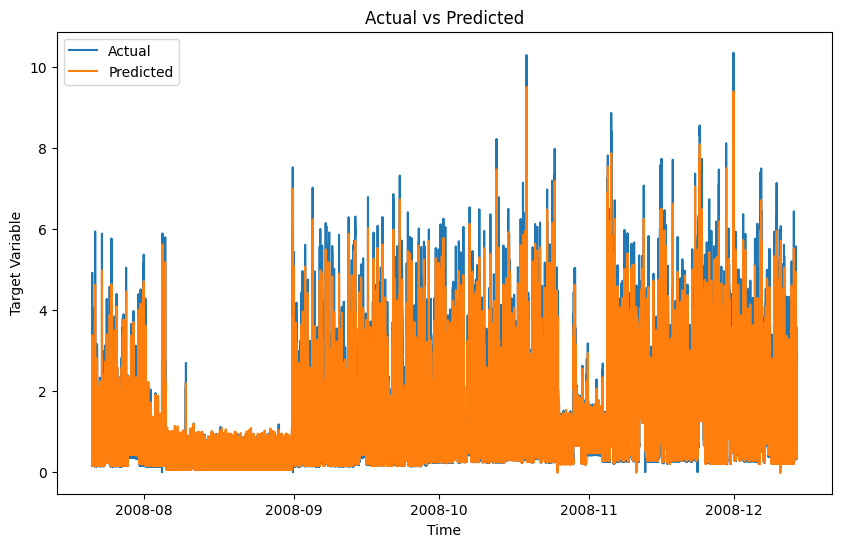

In [69]:
linear_regression = LinearRegression()
linear_regression.fit(x_train, y_train_shift)
y_pred2 = linear_regression.predict(x_test)
plt.figure(figsize=(10, 6))
plt.plot(y_actual.index, y_actual, label='Actual')
plt.plot(y_actual.index, y_pred2, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

In [70]:
np.sqrt(mean_squared_error(y_actual, y_pred2))

0.23269750800181008

In [121]:
tscv = TimeSeriesSplit(n_splits=5)

# Initialize your model (using Linear Regression as an example)
model_lr = LinearRegression()

# List to store the scores for each fold
mse_scores = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(x):
    # Split data into training and testing sets
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training data
    model_lr.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = model_lr.predict(X_test)
    
    # Calculate and store the mean squared error for this fold
    mse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
    mse_scores.append(mse)

# Output the evaluation results
print("MSE scores for each fold:",mse_scores)
print("Average MSE:", np.mean(mse_scores))

MSE scores for each fold: [0.267, 0.26, 0.265, 0.248, 0.238]
Average MSE: 0.2556


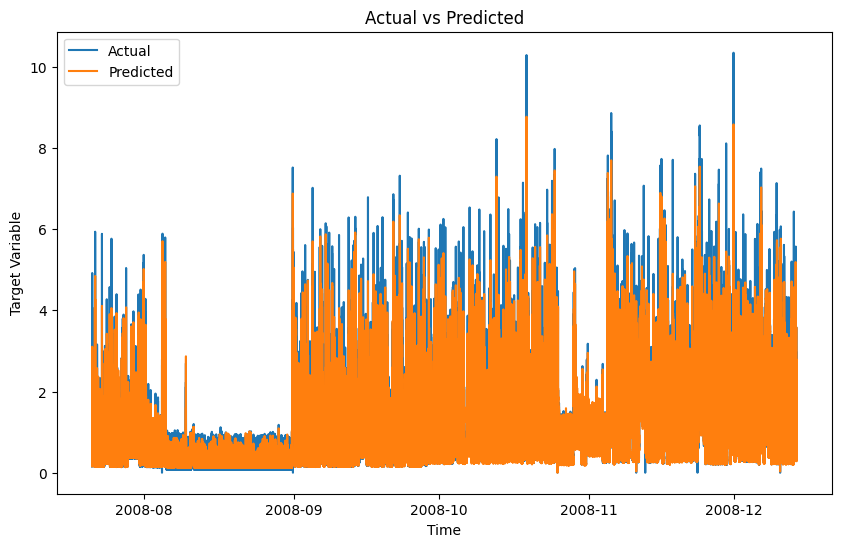

0.2459039550588031


In [114]:
knn_m =KNeighborsRegressor(n_neighbors=16)
knn_m.fit(x_train, y_train_shift)
y_preds3 = knn_m.predict(x_test)
plt.figure(figsize=(10, 6))
plt.plot(y_actual.index, y_actual, label='Actual')
plt.plot(y_actual.index, y_preds3, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()
print(np.sqrt(mean_squared_error(y_actual, y_preds3)))

In [112]:
tscv = TimeSeriesSplit(n_splits=5)

# Initialize your model (using Linear Regression as an example)
model_knn = KNeighborsRegressor(n_neighbors=16)

# List to store the scores for each fold
mse_scores = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(x):
    # Split data into training and testing sets
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training data
    model_knn.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = model_knn.predict(X_test)
    
    # Calculate and store the mean squared error for this fold
    mse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
    mse_scores.append(mse)

# Output the evaluation results
print("MSE scores for each fold:",mse_scores)
print("Average MSE:", np.mean(mse_scores))

MSE scores for each fold: [0.452, 0.256, 0.264, 0.252, 0.233]
Average MSE: 0.2914


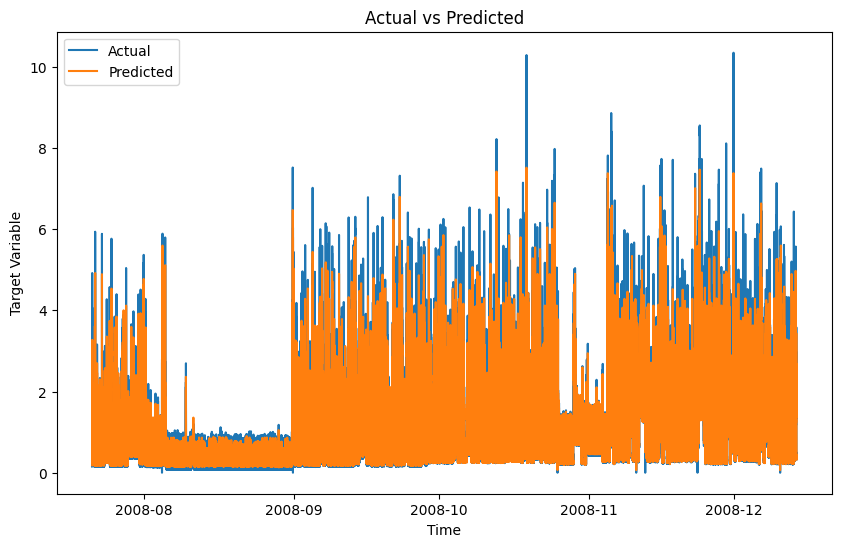

0.2468344457907409


In [115]:
rf_m = XGBRFRegressor(max_depth = 8, n_estimators = 800)
rf_m.fit(x_train, y_train_shift)
y_preds4 = rf_m.predict(x_test)
plt.figure(figsize=(10, 6))
plt.plot(y_actual.index, y_actual, label='Actual')
plt.plot(y_actual.index, y_preds4, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()
print(np.sqrt(mean_squared_error(y_actual, y_preds4)))

In [116]:
tscv = TimeSeriesSplit(n_splits=5)

# Initialize your model (using Linear Regression as an example)
model_rf = XGBRFRegressor(n_estimators = 800, max_depth = 8)

# List to store the scores for each fold
mse_scores = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(x):
    # Split data into training and testing sets
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training data
    model_rf.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = model_rf.predict(X_test)
    
    # Calculate and store the mean squared error for this fold
    mse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
    mse_scores.append(mse)

# Output the evaluation results
print("MSE scores for each fold:",mse_scores)
print("Average MSE:", np.mean(mse_scores))

MSE scores for each fold: [0.279, 0.265, 0.271, 0.282, 0.244]
Average MSE: 0.2682


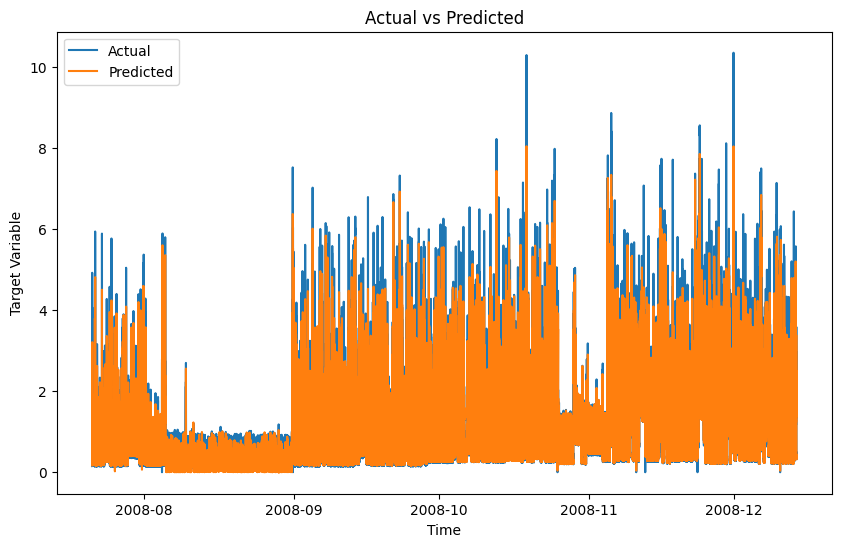

0.23489268519002443


In [117]:
xg_m = XGBRegressor(eta = 0.1, gamma =  0.7, max_depth = 5, min_child_weight =  5)
xg_m.fit(x_train, y_train_shift)
y_preds5 = xg_m.predict(x_test)
plt.figure(figsize=(10, 6))
plt.plot(y_actual.index, y_actual, label='Actual')
plt.plot(y_actual.index, y_preds5, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()
print(np.sqrt(mean_squared_error(y_actual, y_preds5)))

In [118]:
tscv = TimeSeriesSplit(n_splits=5)

# Initialize your model (using Linear Regression as an example)
model_xg = XGBRegressor(eta = 0.1, gamma =  0.7, max_depth = 5, min_child_weight =  5)

# List to store the scores for each fold
mse_scores = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(x):
    # Split data into training and testing sets
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training data
    model_xg.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = model_xg.predict(X_test)
    
    # Calculate and store the mean squared error for this fold
    mse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
    mse_scores.append(mse)

# Output the evaluation results
print("MSE scores for each fold:",mse_scores)
print("Average MSE:", np.mean(mse_scores))

MSE scores for each fold: [0.251, 0.254, 0.261, 0.252, 0.232]
Average MSE: 0.25


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 838860, number of used features: 5
[LightGBM] [Info] Start training from score 1.139183
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


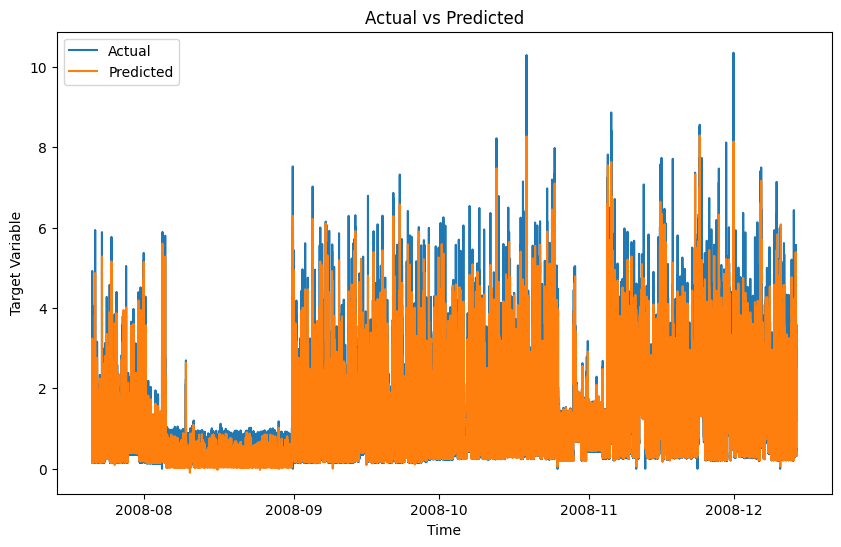

0.23526379716306522


In [119]:
lgbm_m = LGBMRegressor(max_depth = 8, min_child_weight = 1, n_estimators = 300, subsample =  0.6)
lgbm_m.fit(x_train, y_train_shift)
y_preds6 = lgbm_m.predict(x_test)
plt.figure(figsize=(10, 6))
plt.plot(y_actual.index, y_actual, label='Actual')
plt.plot(y_actual.index, y_preds6, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()
print(np.sqrt(mean_squared_error(y_actual, y_preds6)))

In [120]:
tscv = TimeSeriesSplit(n_splits=5)

# Initialize your model (using Linear Regression as an example)
model_lgbm = LGBMRegressor(max_depth = 8, min_child_weight = 1, n_estimators = 300, subsample =  0.6)

# List to store the scores for each fold
mse_scores = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(x):
    # Split data into training and testing sets
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training data
    model_lgbm.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = model_lgbm.predict(X_test)
    
    # Calculate and store the mean squared error for this fold
    mse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
    mse_scores.append(mse)

# Output the evaluation results
print("MSE scores for each fold:",mse_scores)
print("Average MSE:", np.mean(mse_scores))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 174765, number of used features: 5
[LightGBM] [Info] Start training from score 1.414744
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set n

In [122]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D
from tensorflow.keras.callbacks import EarlyStopping



In [132]:
import tensorflow

In [155]:
input = Input(shape = (x_train.shape[-1],1))
x = LSTM(units = 100, return_sequences=True)(input)
x = LSTM(units = 50)(x)
x = Dense(100, activation = 'relu')(x)
x = Dense(50, activation = 'relu')(x)
output = Dense(1)(x)

model_1 = Model(inputs = input, outputs = output)
model_1.compile(loss = 'mse', optimizer = 'adam', metrics = [tensorflow.keras.metrics.RootMeanSquaredError()])
model_1.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 5, 1)]            0         
                                                                 
 lstm_31 (LSTM)              (None, 5, 100)            40800     
                                                                 
 lstm_32 (LSTM)              (None, 50)                30200     
                                                                 
 dense_39 (Dense)            (None, 100)               5100      
                                                                 
 dense_40 (Dense)            (None, 50)                5050      
                                                                 
 dense_41 (Dense)            (None, 1)                 51        
                                                                 
Total params: 81201 (317.19 KB)
Trainable params: 81201 (3

In [156]:
model_1.fit(x_train, y_train_shift, epochs = 10)

Epoch 1/10
 2039/26215 [=>............................] - ETA: 1:21 - loss: 0.2162 - root_mean_squared_error: 0.4649

KeyboardInterrupt: 

In [137]:
pred_1 = model_1.predict(x_test)

print('rmse:', np.sqrt(mean_squared_error(y_actual, pred_1)))

6554/6554 [==============================] - 7s 1ms/step
rmse: 0.22726894248481433


In [171]:
new_df = pd.concat([X, df['Global_active_power']], axis = 1)

In [172]:
new_df

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,Global_active_power
Date_Time,,,,,,
2006-12-16 17:24:00,0.296993,1.634501,-0.447408,-0.161830,4.084721,4.216
2006-12-16 17:25:00,0.317536,1.665571,-0.387731,-0.145854,4.542746,5.360
2006-12-16 17:26:00,0.344262,1.729820,-0.313663,-0.155316,4.970474,5.374
2006-12-16 17:27:00,0.363394,1.787981,-0.267701,-0.140791,5.417992,5.388
2006-12-16 17:28:00,0.349114,1.761661,-0.288263,-0.146293,5.179750,3.666
...,...,...,...,...,...,...
2008-12-13 21:34:00,-0.130060,-0.747185,0.087723,0.052145,-0.023217,0.426
2008-12-13 21:35:00,-0.155087,-0.746097,0.088353,0.052275,-0.024453,0.424
2008-12-13 21:36:00,-0.184195,-0.744863,0.089091,0.052578,-0.024125,0.422


In [173]:
new_df.isnull().sum()

PCA_1                  0
PCA_2                  0
PCA_3                  0
PCA_4                  0
PCA_5                  0
Global_active_power    0
dtype: int64

In [174]:
train_dataset = new_df[:split]
test_dataset = new_df[split:]

from tensorflow.keras.utils import timeseries_dataset_from_array

In [192]:
sequence_length = 50
tf_train_dataset = timeseries_dataset_from_array(train_dataset.to_numpy(), targets= train_dataset['Global_active_power'][sequence_length:], sequence_length = sequence_length, batch_size=512, shuffle=True)
tf_test_dataset = timeseries_dataset_from_array(test_dataset.to_numpy(), targets=test_dataset['Global_active_power'][sequence_length:], sequence_length=sequence_length, batch_size=512)

In [193]:
input = Input(shape = (None, 6))
x = LSTM(units = 100, return_sequences=True)(input)
x = LSTM(units = 50)(x)
output = Dense(1)(x)

model_1 = Model(inputs = input, outputs = output)
model_1.compile(loss = 'mse', optimizer = 'adam', metrics = [tensorflow.keras.metrics.RootMeanSquaredError()])
model_1.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, None, 6)]         0         
                                                                 
 lstm_43 (LSTM)              (None, None, 100)         42800     
                                                                 
 lstm_44 (LSTM)              (None, 50)                30200     
                                                                 
 dense_53 (Dense)            (None, 1)                 51        
                                                                 
Total params: 73051 (285.36 KB)
Trainable params: 73051 (285.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [194]:
model_1.fit(tf_train_dataset, epochs= 10, validation_data=tf_test_dataset)

Epoch 1/10
1639/1639 [==============================] - 410s 249ms/step - loss: 0.0959 - root_mean_squared_error: 0.3096 - val_loss: 0.0511 - val_root_mean_squared_error: 0.2260
Epoch 2/10
1639/1639 [==============================] - 412s 251ms/step - loss: 0.0740 - root_mean_squared_error: 0.2721 - val_loss: 0.0490 - val_root_mean_squared_error: 0.2213
Epoch 3/10
1639/1639 [==============================] - 401s 245ms/step - loss: 0.0714 - root_mean_squared_error: 0.2672 - val_loss: 0.0485 - val_root_mean_squared_error: 0.2203
Epoch 4/10
1639/1639 [==============================] - 407s 248ms/step - loss: 0.0684 - root_mean_squared_error: 0.2615 - val_loss: 0.0460 - val_root_mean_squared_error: 0.2145
Epoch 5/10
1639/1639 [==============================] - 405s 247ms/step - loss: 0.0657 - root_mean_squared_error: 0.2563 - val_loss: 0.0458 - val_root_mean_squared_error: 0.2140
Epoch 6/10
1639/1639 [==============================] - 409s 250ms/step - loss: 0.0637 - root_mean_squared_err

In [197]:
lstm_pred = model_1.predict(tf_test_dataset)

410/410 [==============================] - 39s 93ms/step


In [201]:
actual_values = []
for _, labels in tf_test_dataset:
    actual_values.extend(labels.numpy())

actual_values = np.array(actual_values)

In [202]:
np.sqrt(mean_squared_error(actual_values, lstm_pred.flatten()))

0.2153797485858845

In [204]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

In [206]:
input2 = Input(shape = (None, 6))
x = Conv1D(filters = 100, kernel_size = 3, activation = 'relu')(input2)
x = MaxPooling1D(2)(x)
x = LSTM(units = 100, return_sequences=True)(x)
x = LSTM(units = 50)(x)
output2 = Dense(1)(x)

model_2 = Model(inputs = input2, outputs = output2)
model_2.compile(loss = 'mse', optimizer = 'adam', metrics = [tensorflow.keras.metrics.RootMeanSquaredError()])
model_2.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, None, 6)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 100)         1900      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 100)         0         
 g1D)                                                            
                                                                 
 lstm_47 (LSTM)              (None, None, 100)         80400     
                                                                 
 lstm_48 (LSTM)              (None, 50)                30200     
                                                                 
 dense_55 (Dense)            (None, 1)                 51        
                                                          

In [207]:
model_2.fit(tf_train_dataset, epochs= 10, validation_data=tf_test_dataset)

Epoch 1/10
1639/1639 [==============================] - 313s 189ms/step - loss: 0.1064 - root_mean_squared_error: 0.3262 - val_loss: 0.0565 - val_root_mean_squared_error: 0.2377
Epoch 2/10
1639/1639 [==============================] - 307s 188ms/step - loss: 0.0773 - root_mean_squared_error: 0.2781 - val_loss: 0.0499 - val_root_mean_squared_error: 0.2235
Epoch 3/10
1639/1639 [==============================] - 307s 188ms/step - loss: 0.0726 - root_mean_squared_error: 0.2694 - val_loss: 0.0499 - val_root_mean_squared_error: 0.2234
Epoch 4/10
1639/1639 [==============================] - 307s 187ms/step - loss: 0.0701 - root_mean_squared_error: 0.2648 - val_loss: 0.0481 - val_root_mean_squared_error: 0.2193
Epoch 5/10
1639/1639 [==============================] - 307s 187ms/step - loss: 0.0678 - root_mean_squared_error: 0.2605 - val_loss: 0.0479 - val_root_mean_squared_error: 0.2188
Epoch 6/10
1639/1639 [==============================] - 305s 186ms/step - loss: 0.0661 - root_mean_squared_err

In [208]:
lstm_pred2 = model_2.predict(tf_test_dataset)
np.sqrt(mean_squared_error(actual_values, lstm_pred2.flatten()))


410/410 [==============================] - 29s 71ms/step


0.21514839036550262

In [216]:
input3 = Input(shape = (None, 6))
x = Conv1D(filters = 100, kernel_size = 3, activation = 'relu')(input3)
x = Conv1D(filters = 200, kernel_size = 3, activation = 'relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(filters = 200, kernel_size = 1, activation = 'relu')(x)
x = Conv1D(filters = 100, kernel_size = 1, activation = 'relu')(x)
x = MaxPooling1D(2)(x)
x = LSTM(units = 100, return_sequences=True)(x)
x = LSTM(units = 50)(x)
output3 = Dense(1)(x)

model_3 = Model(inputs = input3, outputs = output3)
model_3.compile(loss = 'mse', optimizer = 'adam', metrics = [tensorflow.keras.metrics.RootMeanSquaredError()])
model_3.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, None, 6)]         0         
                                                                 
 conv1d_5 (Conv1D)           (None, None, 100)         1900      
                                                                 
 conv1d_6 (Conv1D)           (None, None, 200)         60200     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, None, 200)         0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, None, 200)         40200     
                                                                 
 conv1d_8 (Conv1D)           (None, None, 100)         20100     
                                                          

In [217]:
model_3.fit(tf_train_dataset, epochs= 10, validation_data=tf_test_dataset)

Epoch 1/10
1639/1639 [==============================] - 275s 167ms/step - loss: 0.2202 - root_mean_squared_error: 0.4693 - val_loss: 0.1555 - val_root_mean_squared_error: 0.3944
Epoch 2/10
1639/1639 [==============================] - 276s 169ms/step - loss: 0.1904 - root_mean_squared_error: 0.4363 - val_loss: 0.1428 - val_root_mean_squared_error: 0.3779
Epoch 3/10
1639/1639 [==============================] - 274s 167ms/step - loss: 0.1829 - root_mean_squared_error: 0.4276 - val_loss: 0.1394 - val_root_mean_squared_error: 0.3733
Epoch 4/10
1639/1639 [==============================] - 274s 167ms/step - loss: 0.1775 - root_mean_squared_error: 0.4213 - val_loss: 0.1492 - val_root_mean_squared_error: 0.3863
Epoch 5/10
1639/1639 [==============================] - 273s 167ms/step - loss: 0.1731 - root_mean_squared_error: 0.4160 - val_loss: 0.1312 - val_root_mean_squared_error: 0.3623
Epoch 6/10
1639/1639 [==============================] - 276s 168ms/step - loss: 0.1695 - root_mean_squared_err

In [218]:
lstm_pred3 = model_3.predict(tf_test_dataset)
np.sqrt(mean_squared_error(actual_values, lstm_pred3.flatten()))

410/410 [==============================] - 21s 48ms/step


0.3594799675005582

In [219]:
input4 = Input(shape = (None, 6))
x = Conv1D(filters = 100, kernel_size = 3, activation = 'relu')(input4)
x = MaxPooling1D(2)(x)
x = LSTM(units = 200, return_sequences=True)(x)
x = LSTM(units = 150, return_sequences=True)(x)
x = LSTM(units = 50)(x)
output4 = Dense(1)(x)

model_4 = Model(inputs = input4, outputs = output4)
model_4.compile(loss = 'mse', optimizer = 'adam', metrics = [tensorflow.keras.metrics.RootMeanSquaredError()])
model_4.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, None, 6)]         0         
                                                                 
 conv1d_9 (Conv1D)           (None, None, 100)         1900      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, None, 100)         0         
 g1D)                                                            
                                                                 
 lstm_53 (LSTM)              (None, None, 200)         240800    
                                                                 
 lstm_54 (LSTM)              (None, None, 150)         210600    
                                                                 
 lstm_55 (LSTM)              (None, 50)                40200     
                                                          

In [220]:
model_4.fit(tf_train_dataset, epochs= 10, validation_data=tf_test_dataset)

Epoch 1/10
1639/1639 [==============================] - 779s 474ms/step - loss: 0.1083 - root_mean_squared_error: 0.3290 - val_loss: 0.0534 - val_root_mean_squared_error: 0.2311
Epoch 2/10
1639/1639 [==============================] - 786s 480ms/step - loss: 0.0774 - root_mean_squared_error: 0.2781 - val_loss: 0.0510 - val_root_mean_squared_error: 0.2258
Epoch 3/10
1639/1639 [==============================] - 779s 475ms/step - loss: 0.0725 - root_mean_squared_error: 0.2692 - val_loss: 0.0497 - val_root_mean_squared_error: 0.2230
Epoch 4/10
1639/1639 [==============================] - 775s 473ms/step - loss: 0.0695 - root_mean_squared_error: 0.2635 - val_loss: 0.0539 - val_root_mean_squared_error: 0.2321
Epoch 5/10
1639/1639 [==============================] - 777s 474ms/step - loss: 0.0677 - root_mean_squared_error: 0.2602 - val_loss: 0.0476 - val_root_mean_squared_error: 0.2181
Epoch 6/10
1639/1639 [==============================] - 772s 471ms/step - loss: 0.0652 - root_mean_squared_err

In [221]:
lstm_pred4 = model_4.predict(tf_test_dataset)
np.sqrt(mean_squared_error(actual_values, lstm_pred4.flatten()))

410/410 [==============================] - 63s 152ms/step


0.21267794220360448

In [222]:
from tensorflow.keras.layers import Dropout

In [229]:
input5 = Input(shape = (None, 6))
x = Conv1D(filters = 100, kernel_size = 3, activation = 'relu')(input5)
x = MaxPooling1D(2)(x)
x = LSTM(units = 100, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(units = 50)(x)
output5 = Dense(1)(x)

model_5 = Model(inputs = input5, outputs = output5)
model_5.compile(loss = 'mse', optimizer = 'adam', metrics = [tensorflow.keras.metrics.RootMeanSquaredError()])
model_5.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, None, 6)]         0         
                                                                 
 conv1d_13 (Conv1D)          (None, None, 100)         1900      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, None, 100)         0         
 g1D)                                                            
                                                                 
 lstm_62 (LSTM)              (None, None, 100)         80400     
                                                                 
 dropout_5 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_63 (LSTM)              (None, 50)                30200     
                                                          

In [230]:
model_5.fit(tf_train_dataset, epochs= 10, validation_data=tf_test_dataset)

Epoch 1/10


1639/1639 [==============================] - 304s 184ms/step - loss: 0.1175 - root_mean_squared_error: 0.3428 - val_loss: 0.0573 - val_root_mean_squared_error: 0.2393
Epoch 2/10
1639/1639 [==============================] - 299s 182ms/step - loss: 0.0825 - root_mean_squared_error: 0.2872 - val_loss: 0.0511 - val_root_mean_squared_error: 0.2260
Epoch 3/10
1639/1639 [==============================] - 300s 183ms/step - loss: 0.0775 - root_mean_squared_error: 0.2784 - val_loss: 0.0523 - val_root_mean_squared_error: 0.2288
Epoch 4/10
1639/1639 [==============================] - 296s 181ms/step - loss: 0.0746 - root_mean_squared_error: 0.2730 - val_loss: 0.0493 - val_root_mean_squared_error: 0.2221
Epoch 5/10
1639/1639 [==============================] - 296s 180ms/step - loss: 0.0726 - root_mean_squared_error: 0.2694 - val_loss: 0.0501 - val_root_mean_squared_error: 0.2239
Epoch 6/10
1639/1639 [==============================] - 296s 180ms/step - loss: 0.0709 - root_mean_squared_error: 0.2662 

In [231]:
lstm_pred5 = model_5.predict(tf_test_dataset)
np.sqrt(mean_squared_error(actual_values, lstm_pred5.flatten()))

410/410 [==============================] - 27s 63ms/step


0.21360264184503225

In [232]:
input6 = Input(shape = (None, 6))
x = Conv1D(filters = 100, kernel_size = 3, activation = 'relu')(input6)
x = MaxPooling1D(2)(x)
x = LSTM(units = 200, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(units = 150, return_sequences=True)(x)
x = LSTM(units = 50)(x)
x = Dropout(0.2)(x)
output6 = Dense(1)(x)

model_6 = Model(inputs = input6, outputs = output6)
model_6.compile(loss = 'mse', optimizer = 'adam', metrics = [tensorflow.keras.metrics.RootMeanSquaredError()])
model_6.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, None, 6)]         0         
                                                                 
 conv1d_14 (Conv1D)          (None, None, 100)         1900      
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, None, 100)         0         
 g1D)                                                            
                                                                 
 lstm_64 (LSTM)              (None, None, 200)         240800    
                                                                 
 dropout_6 (Dropout)         (None, None, 200)         0         
                                                                 
 lstm_65 (LSTM)              (None, None, 150)         210600    
                                                          

In [233]:
model_6.fit(tf_train_dataset, epochs= 10, validation_data=tf_test_dataset)

Epoch 1/10


1639/1639 [==============================] - 814s 495ms/step - loss: 0.1262 - root_mean_squared_error: 0.3552 - val_loss: 0.0596 - val_root_mean_squared_error: 0.2441
Epoch 2/10
1639/1639 [==============================] - 817s 499ms/step - loss: 0.0918 - root_mean_squared_error: 0.3029 - val_loss: 0.0518 - val_root_mean_squared_error: 0.2277
Epoch 3/10
1639/1639 [==============================] - 830s 506ms/step - loss: 0.0847 - root_mean_squared_error: 0.2910 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2237
Epoch 4/10
1639/1639 [==============================] - 817s 499ms/step - loss: 0.0805 - root_mean_squared_error: 0.2838 - val_loss: 0.0481 - val_root_mean_squared_error: 0.2194
Epoch 5/10
1639/1639 [==============================] - 835s 510ms/step - loss: 0.0779 - root_mean_squared_error: 0.2790 - val_loss: 0.0478 - val_root_mean_squared_error: 0.2187
Epoch 6/10
1639/1639 [==============================] - 818s 499ms/step - loss: 0.0756 - root_mean_squared_error: 0.2750 